In [185]:
import numpy as np
import matplotlib.pyplot as plt
import time

### OvR Kernel Perceptron

In [186]:
class OvRKernelPerceptron:
    def __init__(self, class_labels):
        self.class_labels = class_labels    # list of class labels
        self.classifiers = {}               # dict of alphas for each classifier
        self.prev_examples = {}             # dict of previous examples for each classifier (support vectors)
        # numpy arrays for vectorised operations
        self.prev_examples_arr = {}
        self.classifiers_arr = {}
        self._initialise_classifiers()
    
    def _initialise_classifiers(self):
        for j in self.class_labels:
            self.classifiers[j] = []    # the alphas
            self.prev_examples[j] = []
            self.classifiers_arr[j] = None
            self.prev_examples_arr[j] = None

    # TODO: precompute kernel matrix for all data x_i x_j combos?
    
    def binary_class_prediction(self, x_t, j):
        if len(self.prev_examples[j]) == 0:
            return 0.0
        X = self.prev_examples_arr[j]
        alphas = self.classifiers_arr[j]
        # TODO: predictions = np.array([np.dot(alphas, (X @ x_t) ** d) for d in self.degrees])
        return np.dot(alphas, (X @ x_t) ** 3)
    
    def train_classifiers(self, data, n_epochs):
        mistakes = 0

        # extend data by repeating it n_epochs times
        data = np.vstack([data] * n_epochs)

        for t in range(len(data)):
            true_class = int(data[t][0])
            x_t = data[t][1:257]
            
            # Train each binary classifier
            max_pred = -1e18
            predicted_class = -1
            
            for j in self.class_labels:  
                y = 1.0 if (true_class == j) else -1.0      # OvR label for binary classifier
                y_pred = self.binary_class_prediction(x_t, j)

                # Update if mistake
                if y * y_pred <= 0:     # equivalent to y != 'y_pred'
                    self.classifiers[j].append(y)   # update the alpha
                    # note: only non-zero alphas are stored, as they are effectively support vectors
                    self.prev_examples[j].append(x_t)  # store the example
                    # lazily convert to numpy arrays for vectorised operations
                    self.classifiers_arr[j] = np.array(self.classifiers[j])
                    self.prev_examples_arr[j] = np.array(self.prev_examples[j])
                
                # Track predicted class for error counting
                if y_pred > max_pred:
                    max_pred = y_pred
                    predicted_class = j
            
            # Count mistake if predicted wrong
            if predicted_class != true_class:
                mistakes += 1
                
        error_rate = mistakes / len(data)
        
        return error_rate
    
    def test_classifiers(self, test_data):
        mistakes = 0
        
        for i in range(len(test_data)):
            true_label = int(test_data[i][0])
            x = test_data[i][1:257]
            
            # Get predictions
            max_pred = -1e18
            predicted_class = -1

            for j in self.class_labels:
                # predict (will use relevant training data according to stored support vectors)
                y_pred = self.binary_class_prediction(x, j)
                
                # Track predicted class
                if y_pred > max_pred:
                    max_pred = y_pred
                    predicted_class = j
            
            if predicted_class != true_label:
                mistakes += 1
        
        error_rate = mistakes / len(test_data)
        
        return error_rate
    
    def run(self, train_data, test_data, n_epochs):
        # Training
        start_time = time.time()
        train_error = self.train_classifiers(train_data, n_epochs)
        train_time = time.time() - start_time
        print(f"Training required {train_time:.2f}s "
                f"with a training error of {train_error:.4f}")
        
        # Testing
        start_time = time.time()
        test_error = self.test_classifiers(test_data)
        test_time = time.time() - start_time
        print(f"Testing required {test_time:.2f}s "
                f"with a test error of {test_error:.4f}")


# TODO: Optimized version with vectorization for speed

### Testing

In [187]:
def plot_digit(char_data, ax=None):
    # First element is label, next 256 are pixel values
    label = int(char_data[0])
    pixels = char_data[1:257].reshape(16, 16)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    ax.imshow(pixels, cmap='gray')
    ax.set_title(f'The number {label}')
    ax.axis('off')
    return ax

#### Demo Run with 123 datasets

Training data shape: (329, 257)
Test data shape: (456, 257)


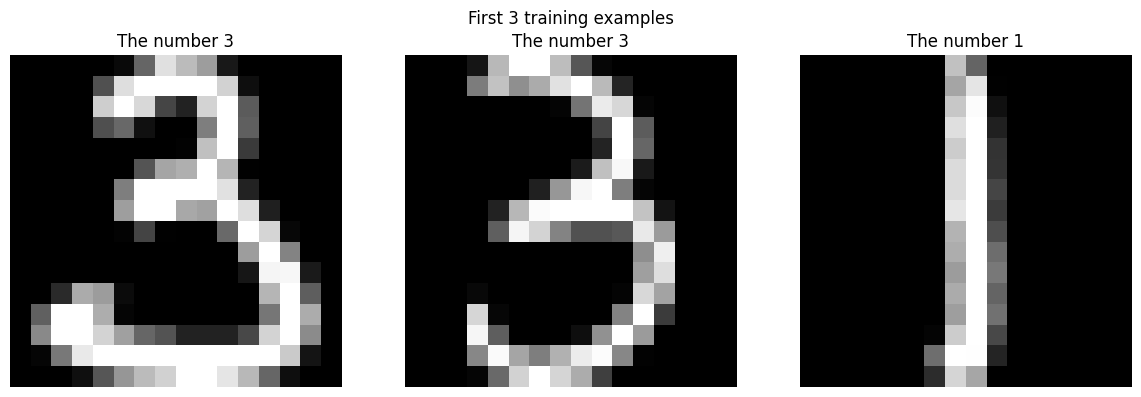


Running Kernel Perceptron Demo...
Training required 0.03s with a training error of 0.0258
Testing required 0.02s with a test error of 0.0263


In [188]:
kp = OvRKernelPerceptron([1, 2, 3])
dtrain123 = np.loadtxt('dtrain123.dat')
dtest123 = np.loadtxt('dtest123.dat')
print(f"Training data shape: {dtrain123.shape}")
print(f"Test data shape: {dtest123.shape}")

# Plot first few digits
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for t in range(3):
    plot_digit(dtrain123[t], axes[t])
plt.suptitle("First 3 training examples")
plt.tight_layout()
plt.show()

# Run demo
print("\nRunning Kernel Perceptron Demo...")
np.random.seed(42)  # for reproducibility
kp.run(dtrain123, dtest123, 2)

#### Basic results with zipcombo dataset, for different degrees of polynomial kernel

class labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Training data shape: (7438, 257)
Test data shape: (1860, 257)


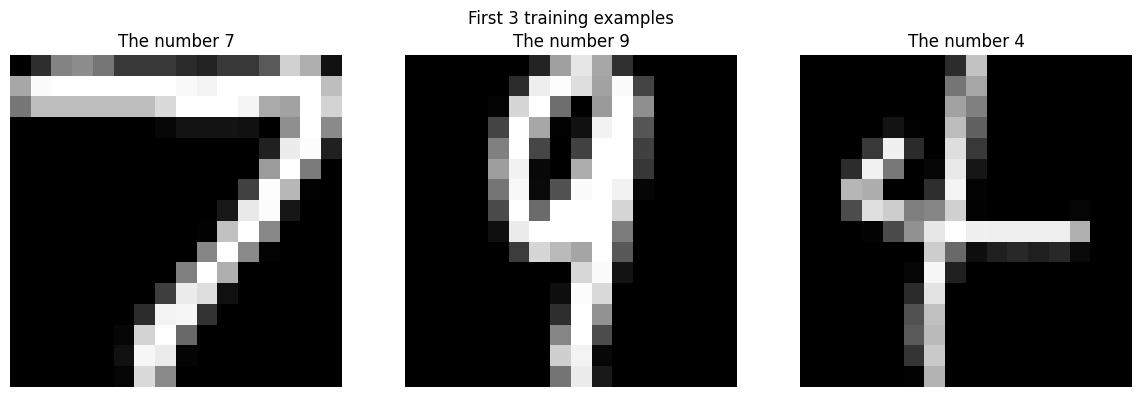


Running Kernel Perceptron Demo...
Training required 8.92s with a training error of 0.0377
Testing required 0.98s with a test error of 0.0274


In [189]:
kp = OvRKernelPerceptron([i for i in range(10)])
print("class labels:", kp.class_labels)
zipcombo = np.loadtxt('zipcombo.dat')
np.random.seed(42)  # for reproducibility

# random split into 80% train and 20% test
#zipcombo = zipcombo[:2000]
np.random.shuffle(zipcombo)
split_index = int(0.8 * len(zipcombo))
train_data = zipcombo[:split_index]
test_data = zipcombo[split_index:]

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Plot first few digits
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for t in range(3):
    plot_digit(train_data[t], axes[t])
plt.suptitle("First 3 training examples")
plt.tight_layout()
plt.show()

# Run demo
print("\nRunning Kernel Perceptron Demo...")
kp.run(train_data, test_data, 3)

# TODO: run on thinlinc if too slow